In [5]:
import numpy as np
import glob
import pandas as pd
import tensorflow as tf

In [6]:
dataset = open('enformer_baseline_datasets.tsv', 'r')
keep_datasets=[]
for k,line in enumerate(dataset.readlines()):
    if k == 0:
        continue
    dataset_name = line.rstrip('\n')
    keep_datasets.append(dataset_name)

In [7]:
files = tf.io.gfile.glob("gs://picard-testing-176520/ATAC_peaks_central512_top100knonpromoter_globalaveragepool/*.tfr")

@tf.function
def deserialize(serialized_example):
    """
    Deserialize bytes stored in TFRecordFile.
    """
    feature_map = {
        'mean_peaks_processed': tf.io.FixedLenFeature([], tf.string)
        
    }

    data = tf.io.parse_example(serialized_example, feature_map)
    
    mean_peaks_processed = tf.ensure_shape(tf.io.parse_tensor(data['mean_peaks_processed'],
                                              out_type=tf.float32),
                           [1536,])

    return {
        'mean_peaks_processed': tf.ensure_shape(mean_peaks_processed,[1536,])
    }



g = tf.random.get_global_generator()

arr_dict ={}
for entry in files:
    if not '-0.tfr' in entry:
        continue
    if 'NEURON_H9' in entry:
        continue
    #if 'T_CELL_CD4POS_EFFECTOR' in entry:
    #    continue
    #if 'HG_A375' in entry:
    #    continue
    if 'HG_HSC_UNK_U_UNK' in entry:
        continue
    name=entry.split('/')[-1].split('.')[0].split('-')[0]
    if name not in keep_datasets:
        continue
    dataset = tf.data.TFRecordDataset(entry,
                                      compression_type='ZLIB',
                                      num_parallel_reads=1)

    dataset = dataset.map(lambda record: deserialize(record),
                          deterministic=False,
                          num_parallel_calls=1)
    dataset= dataset.repeat(1).batch(1)

    out=next(iter(dataset))
    arr_dict[name] = out['mean_peaks_processed'][0,:]


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2022-12-22 19:59:40.441225: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-22 19:59:40.441268: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-22 19:59:40.441297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist
2022-12-22 19:59:40.441874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
df=pd.DataFrame.from_dict(arr_dict)
df_T = df.T
df_T['sample_name']=df_T.index

metadata = pd.read_csv('cell_atac_cluster_Metadata.txt',sep='\t',header=0)

In [9]:
from sklearn.preprocessing import StandardScaler

df_T['sample_name']=df_T.index

features = range(0,1536)
# Separating out the features
x = df_T.loc[:, features].values
y = df_T['sample_name']
x = StandardScaler().fit_transform(x)

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


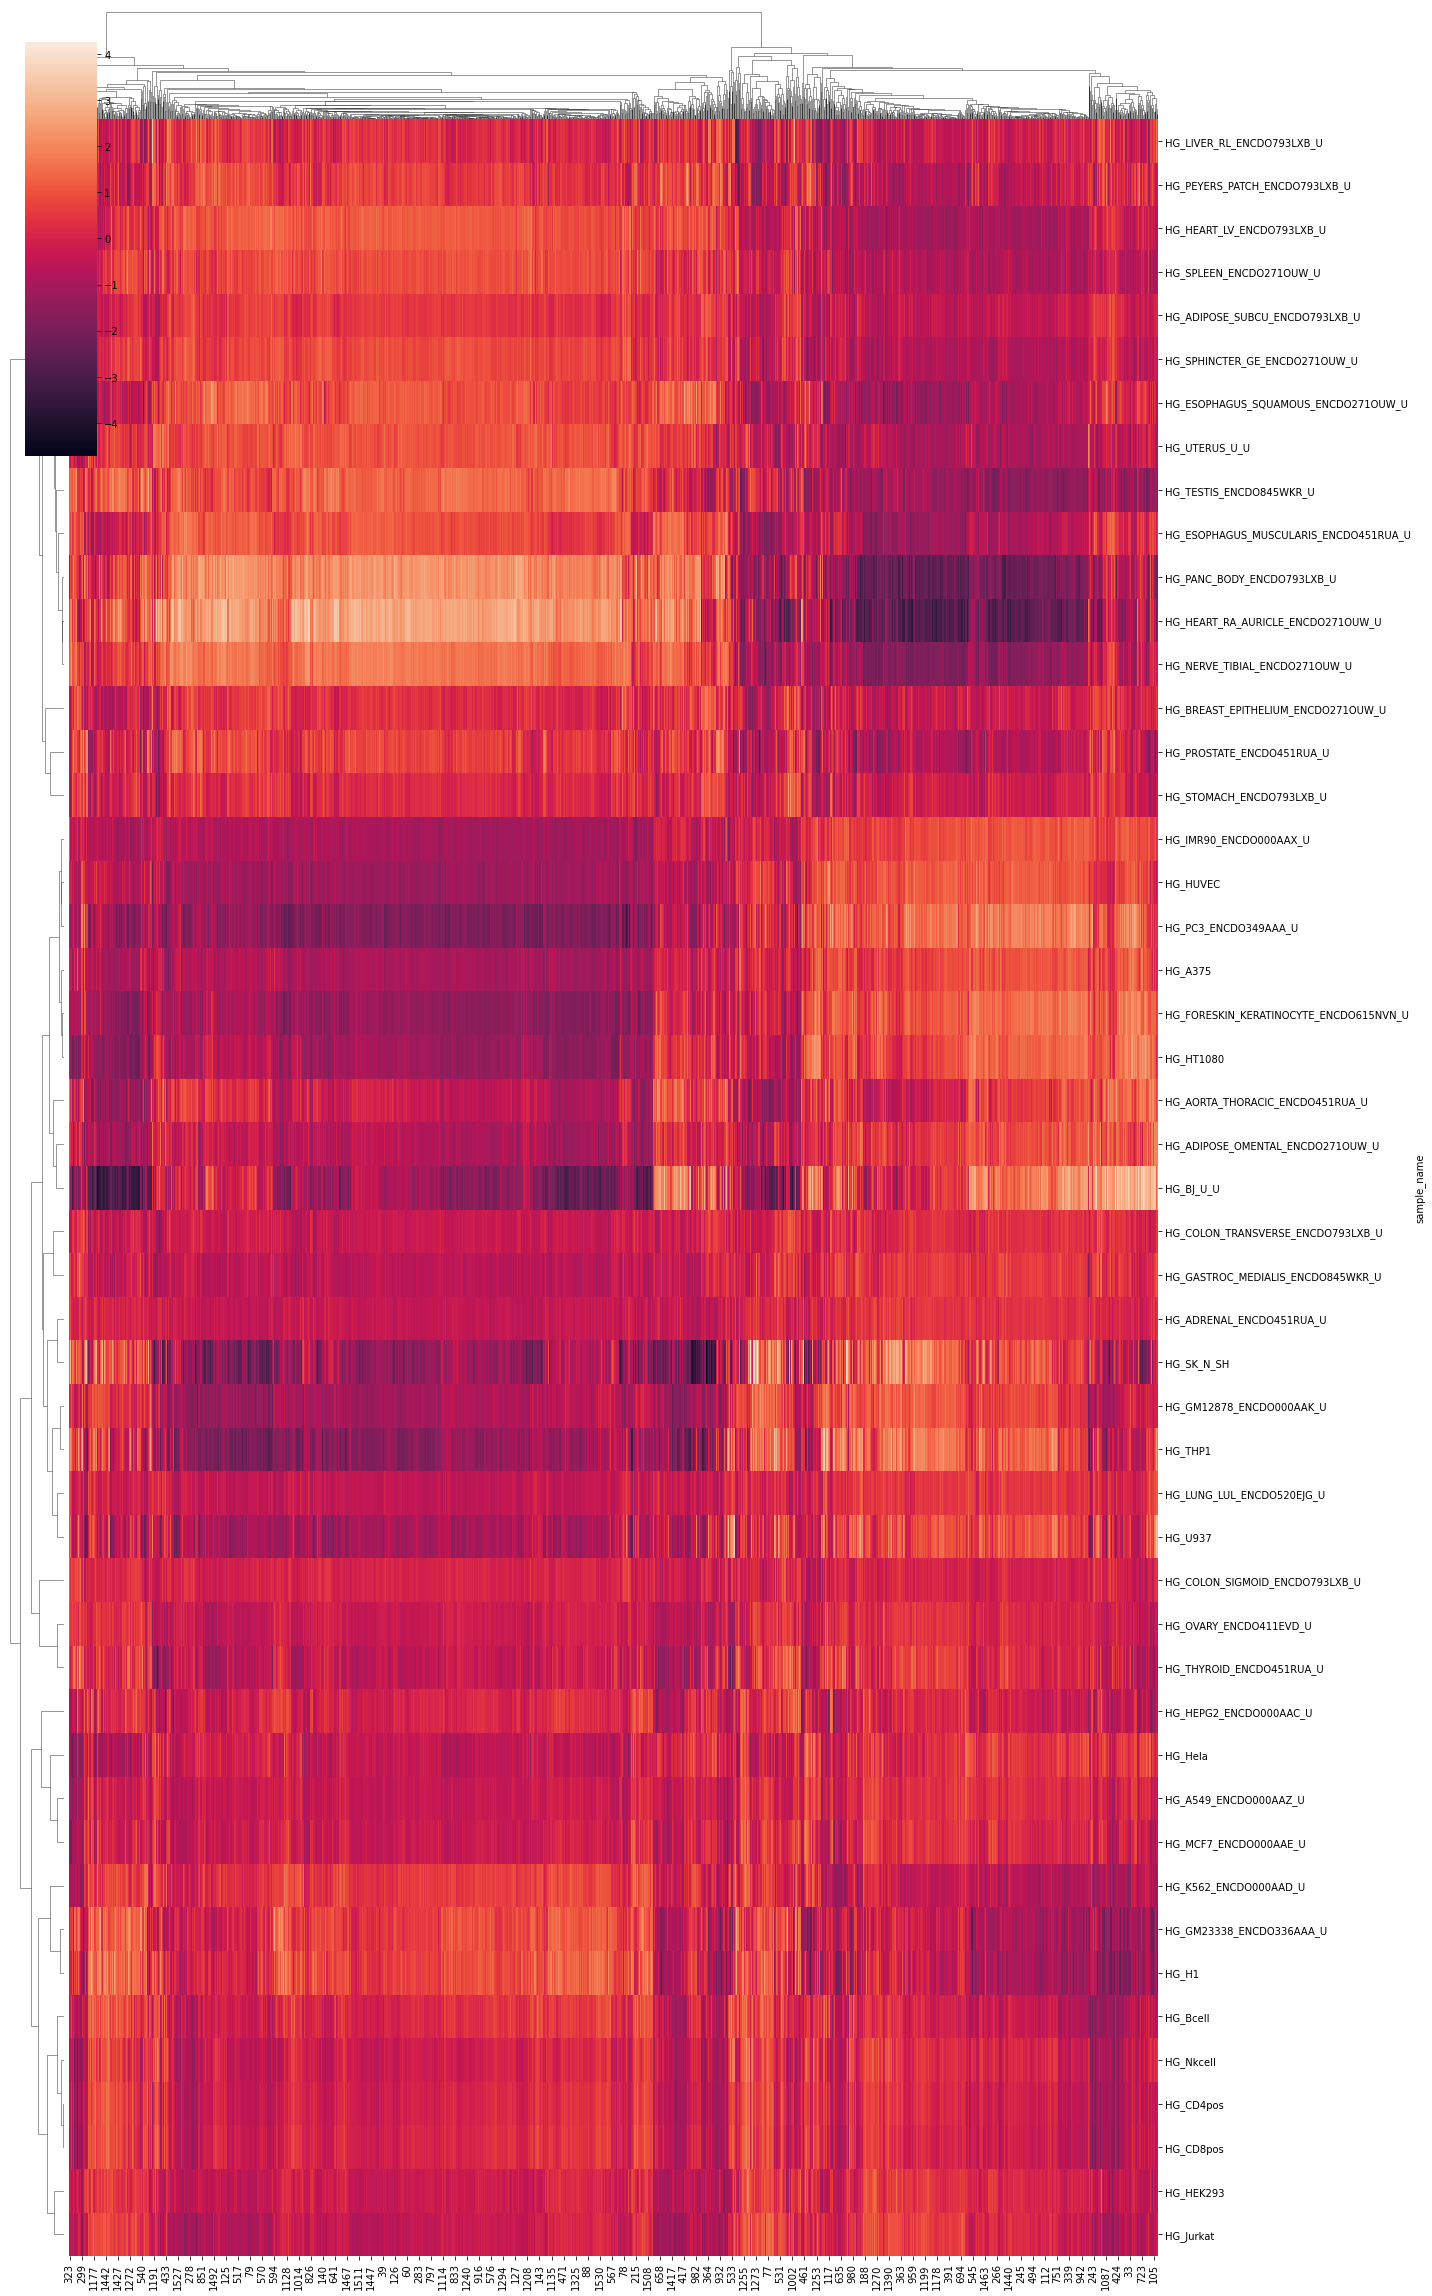

In [10]:
#lut = dict(zip(set(organs), sns.hls_palette(len(set(organs)), l=0.5, s=0.8)))
#row_colors = pd.DataFrame(organs)[0].map(lut)
import seaborn as sns
principalDf = pd.DataFrame(data = x)
principalDf.set_index(y,inplace=True)  
sns.clustermap(principalDf, row_cluster=True,
               col_cluster=True,yticklabels=True,metric='cosine',
               figsize=(20,32),dendrogram_ratio=0.05)

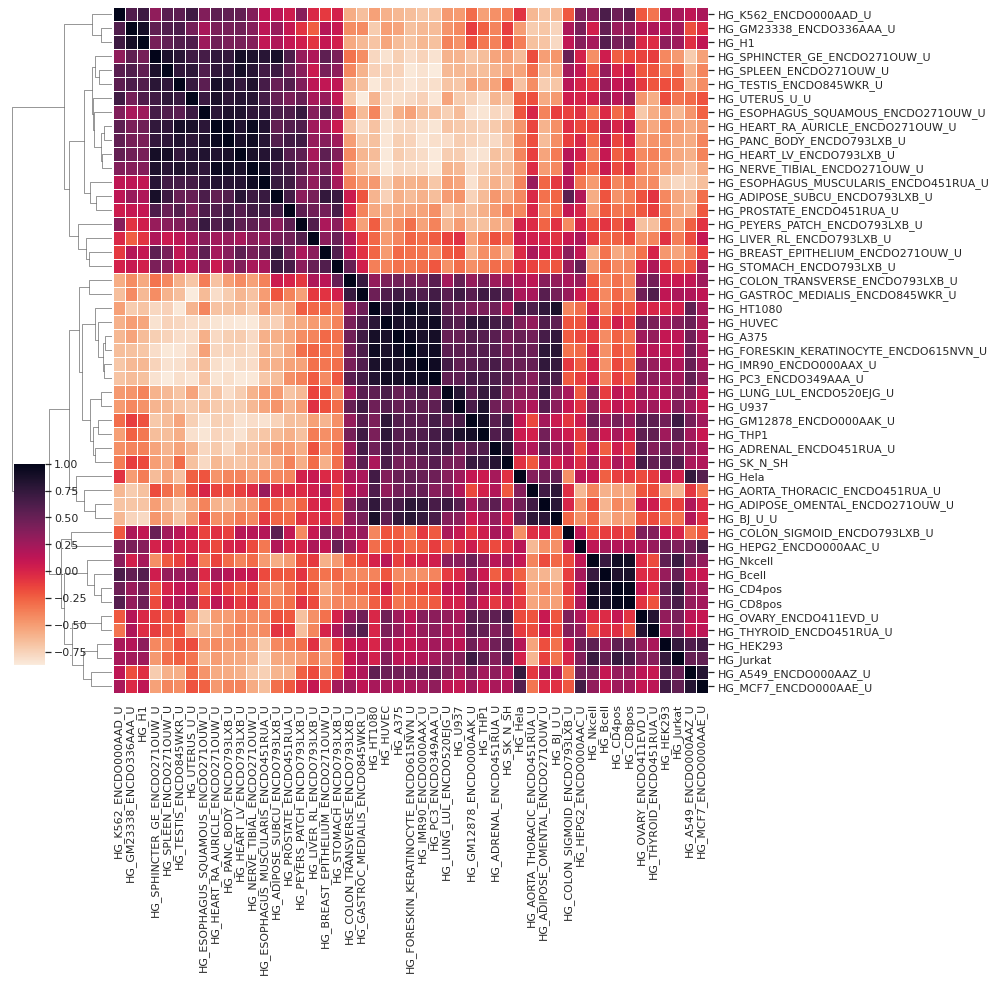

In [12]:
import pandas as pd
import seaborn as sns
sns.set_theme()

#x = df.loc[:, features]
#y = df_T['sample_name']
df=pd.DataFrame.from_dict(arr_dict)
x = df.T.values #returns a numpy array
x=StandardScaler().fit_transform(x)
df_norm = pd.DataFrame(x).T
df_norm.columns = df.columns

from sklearn.metrics.pairwise import cosine_similarity
cos_sim=cosine_similarity(x)
cos_sim_df=pd.DataFrame(cos_sim)
cos_sim_df.set_index(df.columns,inplace=True)
cos_sim_df.columns=df.columns

# Draw the full plot
cmap = sns.cm.rocket_r
g = sns.clustermap(cos_sim_df,
                   metric='euclidean',
                   cmap=cmap,row_cluster=True,
                   col_cluster=True,yticklabels=True,
                   dendrogram_ratio=(.15, .02),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(14, 14))

g.ax_col_dendrogram.remove()
#g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 8)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


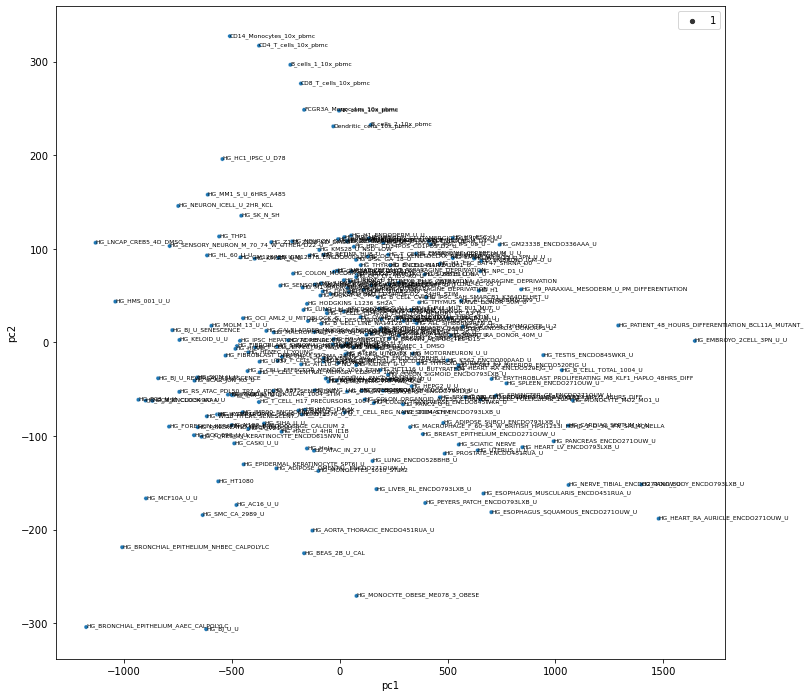

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features = range(0,1536)
# Separating out the features
x = df_T.loc[:, features].values
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
y = df_T['sample_name'].reset_index()['sample_name']
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.columns=['pc1','pc2','sample_name']

#finalDf = pd.merge(finalDf,metadata,left_on="sample_name",right_on="sample_name")
    
a4_dims = (12, 12)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(finalDf.loc[:, 'pc1'],
                finalDf.loc[:, 'pc2'],
                #hue=finalDf.loc[:, 'cell_class'],
            size=1)
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

for k,row in finalDf.iterrows():
    if k % 1 == 0:
        ax.annotate(row['sample_name'], (row['pc1'], 
                             row['pc2']),fontsize=6)

plt.savefig('peaks_processed_PCA.pdf')  

In [201]:
finalDf

,pc1,pc2,sample_name,cell_class
0,6.603478,-41.173244,HG_A549_ENCDO000AAZ_U,epithelial
1,-699.674622,244.731522,HG_AC16_U_U,heart
2,-229.096436,66.324211,HG_ADIPOSE_OMENTAL_ENCDO271OUW_U,adipose
3,658.154480,45.985886,HG_ADIPOSE_SUBCU_ENCDO793LXB_U,adipose
4,-29.883156,33.685280,HG_ADRENAL_ENCDO451RUA_U,adrenal
...,...,...,...,...
211,-161.719254,-16.551476,HG_VENA_CAVA_POST_ENCDO528BHB_U,vascular
212,-1162.648193,144.318207,HG_WI38_HTERT_SENESCENT,fibroblast
213,675.427979,-72.780983,HG_WTC_11_U_,stem
214,-389.068512,-95.449829,HG_Z138_Z138_KD_DMSO,lymphoblast


In [95]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(x)
finalDf_umap = pd.concat([pd.DataFrame(embedding), y], axis = 1)
finalDf_umap.columns=['umap1','umap2','sample_name']
finalDf = pd.merge(finalDf,metadata,left_on="sample_name",right_on="sample_name")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


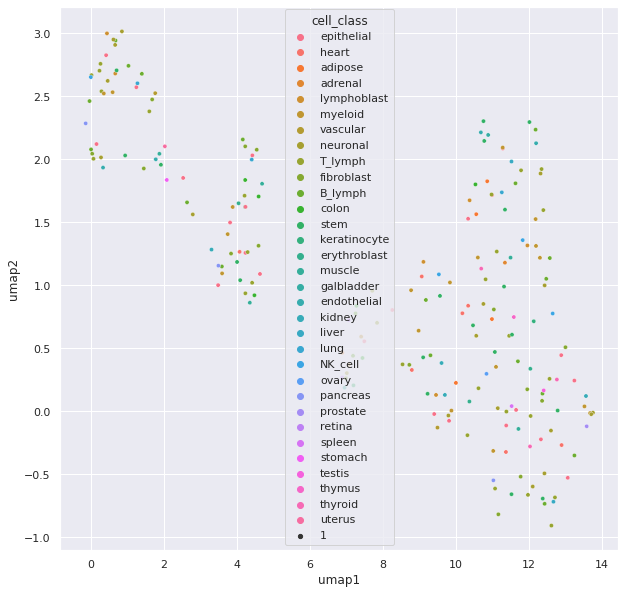

In [215]:

a4_dims = (10, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(finalDf_umap.loc[:, 'umap1'],
                finalDf_umap.loc[:, 'umap2'],
                hue=finalDf.loc[:, 'cell_class'],
            size=1)
#for k in range(embedding.shape[0]):
#    ax.annotate(y.values[k], (embedding[k,0], 
#                         embedding[k,1]),fontsize=4)
plt.savefig('line_plot.pdf')  

In [188]:
df_T

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
HG_A375-0,98.059074,-119.831657,223.863968,73.754684,-84.759796,-95.632591,-95.826469,-22.889887,-91.305969,-4.929729,...,-78.215950,-50.685223,-69.649910,-102.312317,-167.635010,-190.182510,-96.000038,-65.089943,-96.980629,71.797722
HG_A549_ENCDO000AAZ_U-0,102.646309,-105.510139,202.421204,66.262352,-81.688728,-91.643867,-88.684395,-19.777245,-89.179420,-1.211610,...,-83.209953,-50.134243,-69.708595,-94.723846,-144.726669,-175.326523,-87.825829,-64.683434,-90.849884,64.333183
HG_AC16_U_U-0,97.780823,-126.492554,240.185837,75.112183,-82.585526,-99.140976,-91.828445,-22.914745,-90.492149,-8.317450,...,-76.113876,-43.825390,-67.695793,-98.321602,-173.049652,-187.745209,-99.915855,-64.443611,-98.870445,76.026680
HG_ADIPOSE_OMENTAL_ENCDO271OUW_U-0,102.099007,-119.983398,210.527908,69.825020,-79.711319,-94.174805,-93.726074,-22.559561,-85.852257,-4.616909,...,-79.487602,-46.531296,-70.603630,-99.433357,-157.100372,-171.699539,-94.807213,-66.920898,-94.636353,68.487343
HG_ADIPOSE_SUBCU_ENCDO793LXB_U-0,101.683083,-103.616394,201.562500,65.774315,-74.849068,-90.307228,-82.197769,-19.867098,-82.681587,-0.152984,...,-79.696045,-43.772198,-73.904640,-88.221718,-139.256546,-154.768417,-80.342949,-52.454365,-88.068169,65.139549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HG_UTERUS_U_U-0,102.444443,-99.251053,190.985672,62.680092,-75.962646,-90.663330,-77.226913,-17.855721,-81.291573,2.138618,...,-79.957352,-42.650314,-71.513184,-84.197708,-131.618927,-155.385742,-76.760452,-49.826550,-86.357529,59.002300
HG_VENA_CAVA_POST_ENCDO528BHB_U-0,101.707207,-117.695351,204.039062,68.507942,-80.026512,-92.484642,-94.445610,-21.489319,-84.861763,-4.697712,...,-79.697105,-49.552109,-73.725021,-100.104408,-153.884720,-172.683044,-93.589912,-67.367378,-92.282738,63.562481
HG_WI38_HTERT_SENESCENT-0,98.545082,-127.709167,240.062393,75.343620,-85.987946,-100.229332,-98.024254,-23.569677,-95.526527,-7.027962,...,-79.323891,-51.165943,-71.005547,-105.335968,-173.920059,-199.582840,-101.542641,-72.060051,-101.746361,77.174553
HG_WTC_11_U_-0,103.137474,-95.933235,181.622787,61.358776,-83.248291,-91.518257,-78.234192,-17.462700,-84.285553,2.207132,...,-84.454575,-50.422802,-76.464615,-89.309807,-124.871895,-164.234085,-71.268982,-48.280537,-89.830139,61.088474


In [36]:
import tensorflow as tf
from tensorflow import strings as tfs
def one_hot(sequence):
    '''
    convert input string tensor to one hot encoded
    will replace all N character with 0 0 0 0
    '''
    vocabulary = tf.constant(['A', 'C', 'G', 'T'])
    mapping = tf.constant([0, 1, 2, 3])

    init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                               values=mapping)
    table = tf.lookup.StaticHashTable(init, default_value=5) # makes N correspond to all 0s

    input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))

    out = tf.one_hot(table.lookup(input_characters), 
                      depth = 4, 
                      dtype=tf.float32)
    return out

In [204]:
df

,HG_A375,HG_A549_ENCDO000AAZ_U,HG_AC16_U_U,HG_ADIPOSE_OMENTAL_ENCDO271OUW_U,HG_ADIPOSE_SUBCU_ENCDO793LXB_U,HG_ADRENAL_ENCDO451RUA_U,HG_ADRENAL_ENCDO575EGL_U,HG_ALL_SJHBBBM5GW9_U,HG_ALL_SJHBBBN9RFN_U,HG_AML_IPSC_U_U,...,HG_T_CELL_FOLLICULAR_1004_U,HG_T_CELL_H17_PRECURSORS_1004_STIM,HG_T_CELL_REG_NAIVE_1004_STIM,HG_U937,HG_UOCB1_U_U,HG_UTERUS_U_U,HG_VENA_CAVA_POST_ENCDO528BHB_U,HG_WI38_HTERT_SENESCENT,HG_WTC_11_U_,HG_Z138_Z138_KD_DMSO
0,98.059074,102.646309,97.780823,102.099007,101.683083,101.526123,99.573067,105.155663,104.386200,100.089287,...,106.288277,101.068291,104.387451,108.084511,103.545113,102.444443,101.707207,98.545082,103.137474,106.945351
1,-119.831657,-105.510139,-126.492554,-119.983398,-103.616394,-111.953667,-115.355919,-97.434387,-102.859352,-109.424438,...,-100.476334,-121.496498,-108.976944,-119.855774,-105.144753,-99.251053,-117.695351,-127.709167,-95.933235,-111.857895
2,223.863968,202.421204,240.185837,210.527908,201.562500,207.684280,207.980270,175.785217,181.746567,202.307816,...,192.199280,213.343475,202.207932,200.531815,184.516968,190.985672,204.039062,240.062393,181.622787,189.522079
3,73.754684,66.262352,75.112183,69.825020,65.774315,66.060318,67.989235,61.467754,62.871231,64.397614,...,62.733742,69.484703,66.004173,70.677002,64.496338,62.680092,68.507942,75.343620,61.358776,63.817310
4,-84.759796,-81.688728,-82.585526,-79.711319,-74.849068,-80.913269,-81.430214,-78.054588,-79.081078,-83.595558,...,-79.975464,-86.195175,-83.471710,-83.337593,-79.182709,-75.962646,-80.026512,-85.987946,-83.248291,-89.250923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,-190.182510,-175.326523,-187.745209,-171.699539,-154.768417,-168.204025,-177.003784,-156.130722,-162.668289,-172.533646,...,-157.240082,-184.946808,-174.225723,-176.055374,-161.313705,-155.385742,-172.683044,-199.582840,-164.234085,-186.301437
1532,-96.000038,-87.825829,-99.915855,-94.807213,-80.342949,-88.183846,-94.238991,-77.934883,-81.765129,-88.512634,...,-78.750565,-99.972420,-86.368217,-95.200775,-81.402000,-76.760452,-93.589912,-101.542641,-71.268982,-86.147377
1533,-65.089943,-64.683434,-64.443611,-66.920898,-52.454365,-59.396671,-69.418266,-57.255585,-61.353359,-63.167858,...,-50.555260,-72.263298,-59.857651,-72.313133,-57.225651,-49.826550,-67.367378,-72.060051,-48.280537,-65.715225
1534,-96.980629,-90.849884,-98.870445,-94.636353,-88.068169,-91.250145,-90.439583,-87.909935,-89.883003,-92.884773,...,-89.334671,-97.082474,-94.280930,-97.054108,-89.272705,-86.357529,-92.282738,-101.746361,-89.830139,-95.874512


In [40]:
test

<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [262]:
principalDf

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,,,,,,,,,,,,,,,,,,,,,
HG_AORTA_THORACIC_ENCDO451RUA_U,-2.355674,-0.611306,-0.726434,-1.787224,-1.559819,0.290123,0.186393,-0.006297,-1.867251,0.759904,...,0.333249,-1.165885,0.355970,-0.921839,0.802468,-0.311656,-0.817224,-0.495247,-0.817535,-0.528991
HG_ALL_SJHBBBN9RFN_U,0.416277,0.881344,-0.575977,-0.212383,0.926001,0.358183,-0.394181,0.073520,-0.453583,0.457891,...,-0.184831,-0.276665,0.601056,-0.418379,0.642308,0.772220,0.908787,-0.684189,-0.497222,-0.588752
HG_ADRENAL_ENCDO575EGL_U,0.685792,-0.129087,0.934080,1.204530,0.431023,-0.574461,0.173269,-0.259226,0.588293,-0.970077,...,-0.442900,0.970751,-0.748838,0.758534,-1.028588,-0.334718,-0.450807,1.033787,0.764873,0.710147
HG_BEAS_2B_U_CAL,0.117219,0.822490,-1.204793,-1.189328,0.509403,1.211307,-1.256217,1.130060,-0.296538,1.112267,...,1.182845,-1.185319,1.331010,-1.226326,0.920227,1.048452,0.866096,-1.150188,-1.763956,-1.110731
HG_AC16_U_U,1.360902,-0.082827,0.117193,0.116455,0.348859,0.471650,-0.527170,0.763569,1.389269,0.168436,...,1.089844,0.162444,0.056890,-0.347110,-0.466771,-0.177314,-0.172689,-0.154914,-0.791493,0.010937
HG_ATL10_U_NO_TX,-0.683642,0.470603,-0.510244,-0.635260,-0.009700,0.296062,0.146260,-0.595813,-1.167142,0.759203,...,-0.333245,-0.849842,0.499677,-0.358977,1.030245,0.532133,0.405296,-0.736298,-0.454556,-0.401249
HG_ATL25_U_NO_TX,-1.860396,0.611655,-0.662371,-0.397723,-0.788924,0.262541,0.317905,0.012210,-2.130101,0.478701,...,-0.563458,-1.496824,0.493628,-0.285721,1.285839,0.338091,0.495987,-0.837729,-0.176227,-0.117569
HG_ATAC_IN_27_U_U,0.576764,-0.068036,-0.421049,-0.648544,0.184440,0.751883,-0.872348,1.196776,0.760613,0.361805,...,1.917049,-0.272744,0.262983,-0.695733,-0.053902,0.054778,0.561061,-0.088797,-0.021143,-0.294614
HG_BJ_U_SENESCENCE,-0.876399,-2.301391,2.131693,1.645955,-1.673732,-2.435532,2.388857,-2.163131,0.665785,-2.334552,...,-2.037961,1.996009,-2.228164,2.209675,-1.898839,-2.231787,-2.068462,2.080991,1.877115,2.165715


In [59]:
finalDf

,pc1,pc2,0,pc1_jitter,pc2_jitter
0,43.294816,8.159826,HG_ERYTHROBLAST_PROLIFERATING_M8_KLF1_HAPLO_48...,43.294816,8.159826
1,-0.582282,-5.740697,HG_COLON_SIGMOID_ENCDO793LXB_U,-0.582282,-5.740697
2,-47.560045,7.573421,HG_FORESKIN_KERATINOCYTE_ENCDO615NVN_U,-47.560045,7.573421
3,-7.849266,4.799264,HG_T_CELL_CD4POS_CD25NEG_DONOR_1_JAK3_U,-7.849266,4.799264
4,20.963720,-1.401124,HG_HEART_RA_ENCDO520EJG_U,20.963720,-1.401124
...,...,...,...,...,...
1459,-27.809734,-8.069363,HG_M2_MACROPHAGE_U_STIM_24HRS,-27.809734,-8.069363
1460,14.986218,-8.885807,HG_HEART_RA_ENCDO520EJG_U,14.986218,-8.885807
1461,-20.382551,-6.922145,HG_AML_IPSC_U_U,-20.382551,-6.922145
1462,23.177392,-11.331910,HG_HEK293_U_TNFA_12HR,23.177392,-11.331910


In [1]:
import tensorflow as tf

2022-12-19 00:39:00.691109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 00:39:00.691158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
tf.random.experimental.index_shuffle(tf.range(10),[0,1],9)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 8, 5, 4, 3, 2, 6, 0, 9, 7], dtype=int32)>

In [10]:
tf.random.experimental.index_shuffle(tf.range(10),[1,2],9)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([5, 0, 1, 4, 3, 6, 9, 8, 7, 2], dtype=int32)>

In [12]:
g = tf.random.get_global_generator()

In [4]:
import tensorflow as tf

In [228]:
from tensorflow import strings as tfs
def one_hot(sequence):
    '''
    convert input string tensor to one hot encoded
    will replace all N character with 0 0 0 0
    '''
    vocabulary = tf.constant(['A', 'C', 'G', 'T'])
    mapping = tf.constant([0, 1, 2, 3])

    init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                               values=mapping)
    table = tf.lookup.StaticHashTable(init, default_value=5) # makes N correspond to all 0s

    input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))

    out = tf.one_hot(table.lookup(input_characters), 
                      depth = 4, 
                      dtype=tf.float32)
    return out

def rev_comp_one_hot(sequence):
    '''
    convert input string tensor to one hot encoded
    will replace all N character with 0 0 0 0
    '''
    input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))
    input_characters = tf.reverse(input_characters,[0])
    
    vocabulary = tf.constant(['T', 'G', 'C', 'A'])
    mapping = tf.constant([0, 1, 2, 3])

    init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                               values=mapping)
    table = tf.lookup.StaticHashTable(init, default_value=1)

    out = tf.one_hot(table.lookup(input_characters), 
                      depth = 4, 
                      dtype=tf.float32)
    return out


@tf.function
def random_encode(input_tuple):
    sequence, randint = input_tuple
    if randint == 0:
        return one_hot(sequence)
    else:
        return rev_comp_one_hot(sequence)
    
    

@tf.function
def deserialize(serialized_example):
    """
    Deserialize bytes stored in TFRecordFile.
    """
    feature_map = {
        'mean_peaks_processed': tf.io.FixedLenFeature([], tf.string)
        
    }

    data = tf.io.parse_example(serialized_example, feature_map)
    
    mean_peaks_processed = tf.ensure_shape(tf.io.parse_tensor(data['mean_peaks_processed'],
                                              out_type=tf.float32),
                           [1536,])

    return {
        'mean_peaks_processed': tf.ensure_shape(mean_peaks_processed,[1536,])
    }


dataset = tf.data.TFRecordDataset("gs://picard-testing-176520/test/test.tfr",
                                  compression_type='ZLIB',
                                  num_parallel_reads=1)

dataset = dataset.map(lambda record: deserialize(record),
                      deterministic=False,
                      num_parallel_calls=1)
dataset= dataset.repeat(1).batch(1)

out=next(iter(dataset))

In [444]:
out

{'mean_peaks_processed': <tf.Tensor: shape=(1, 1536), dtype=float32, numpy=
 array([[  82.37484 , -169.60004 ,  368.2863  , ...,  153.4289  ,
           -8.659243,  211.20956 ]], dtype=float32)>}

In [124]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [281]:
df_T['organ'].to_series()

AttributeError: 'Series' object has no attribute 'to_series'

In [204]:
np_arr = np.array([5.1,4.9,4.7,4.6,5.0])

In [207]:
(np_arr - np.mean(np_arr)) / np.std(np_arr)

array([ 1.29399328,  0.21566555, -0.86266219, -1.40182605,  0.75482941])

In [206]:
np.std(np_arr)

0.1854723699099141

In [437]:
test=np.array([[1,2,3,4,5]])

In [438]:
test1=np.array([[10,20,30,40,50]])

In [439]:
test2=np.concatenate([test,test1],axis=0)

In [440]:
np.mean(test2,axis=0)

array([ 5.5, 11. , 16.5, 22. , 27.5])